In [2]:
import wget
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [4]:
data= "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
data= wget.download(data)
df= pd.read_csv(data)

100% [..........................................................................] 1475504 / 1475504

# Preparing the dataset

In [5]:
df2 = df.copy()
df2= df[["Make","Model","Year","Engine HP","Engine Cylinders","Transmission Type","Vehicle Style","highway MPG","city mpg","MSRP"]]

In [6]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')

In [7]:
df2 = df2.fillna(0)

In [25]:
df2["above_average"] = pd.Series(np.where(df2.msrp>df2.msrp.mean(),1,0))

In [68]:
df2_train_full, df2_test = train_test_split(df2, test_size=0.2, random_state=1)
df2_train, df2_val = train_test_split(df2_train_full, test_size=0.25, random_state=1)

y_train = df2_train.above_average.values
y_val = df2_val.above_average.values
y_test = df2_test.above_average.values


#df2_train = df2_test.drop(columns=["above_average","msrp"],axis=1) NO SE PUEDEN USAR PORQUE ALTERAN FILAS
#df2_val= df2_val.drop(columns=["above_average","msrp"],axis=1)
#df2_test= df2_test.drop(columns=["above_average","msrp"],axis=1)

del df2_train["above_average"]
del df2_train["msrp"]
del df2_val["above_average"]
del df2_val["msrp"]
del df2_test["above_average"]
del df2_test["msrp"]
#del df2_val["above_average"]
#del df2_test["above_average"]

### Question 1

In [110]:
numerical= ["city_mpg","highway_mpg","engine_cylinders","engine_hp","year"]
categorical = ["vehicle_style","transmission_type","model","make"]

In [89]:
for c in numerical:
    auc = roc_auc_score(y_train, df2_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df2_train[c])
    print('%9s, %.3f' % (c, auc))

 city_mpg, 0.673
highway_mpg, 0.633
engine_cylinders, 0.766
engine_hp, 0.917
     year, 0.688


The highest value is for engine_hp

### Question 2

In [ ]:
 cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


In [72]:
train_dic2=df2_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train2 = dv.fit_transform(train_dic2)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train2, y_train)

val_dict2 = df2_val.to_dict(orient='records')
X_val2 = dv.transform(val_dict2)

y_pred = model.predict_proba(X_val2)[:, 1]
round(roc_auc_score(y_val,y_pred),4)

0.9802

### Question 3

In [78]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    

    return df_scores

In [80]:
df_scores=tpr_fpr_dataframe(y_val, y_pred)

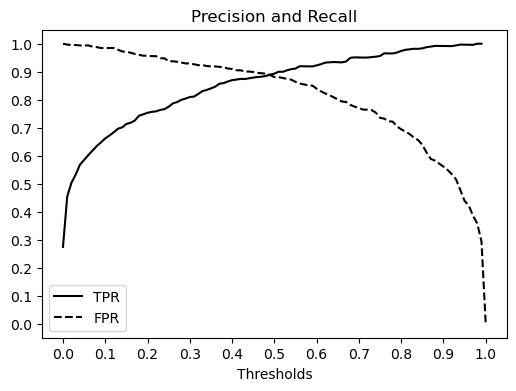

In [81]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.recall, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('Precision and Recall')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

In [91]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000
1,0.01,652,784,2,945,0.996942,0.453441,0.454039,0.996942
2,0.02,651,642,3,1087,0.995413,0.371313,0.503480,0.995413
3,0.03,651,572,3,1157,0.995413,0.330827,0.532298,0.995413
4,0.04,650,495,4,1234,0.993884,0.286293,0.567686,0.993884
...,...,...,...,...,...,...,...,...,...
96,0.96,276,1,378,1728,0.422018,0.000578,0.996390,0.422018
97,0.97,252,1,402,1728,0.385321,0.000578,0.996047,0.385321
98,0.98,234,0,420,1729,0.357798,0.000000,1.000000,0.357798
99,0.99,192,0,462,1729,0.293578,0.000000,1.000000,0.293578


In [97]:
threshold = df_scores.loc[df_scores['precision'] == df_scores['recall'], 'threshold']
print(threshold)

Series([], Name: threshold, dtype: float64)


The value where TPR and FRP are closest is near threshold=0,48

### Question 4

In [98]:
df_scores["F1"]=(df_scores["precision"]*df_scores["recall"])/(df_scores["precision"]+df_scores["recall"])


In [100]:
 df_scores.loc[df_scores["F1"].idxmax(), 'threshold']

0.51

### Question 5

In [102]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [132]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [133]:
aucs = []

for train_idx, val_idx in kfold.split(df2_train_full):
    df_train = df2_train_full.iloc[train_idx]
    y_train = df_train.above_average.values

    df_val = df2_train_full.iloc[val_idx]
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [134]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.979 ± 0.002


### Question 6

In [136]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [137]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df2_train_full):
        df_train = df2_train_full.iloc[train_idx]
        y_train = df_train.above_average.values

        df_val = df2_train_full.iloc[val_idx]
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        rocauc = roc_auc_score(y_val, y_pred)
        aucs.append(rocauc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.935 ± 0.003
C=0.01, auc = 0.952 ± 0.002
C=0.1, auc = 0.972 ± 0.002
C=0.5, auc = 0.978 ± 0.003
C=1, auc = 0.979 ± 0.002
C=10, auc = 0.984 ± 0.003


The best value for C in terms of AUC is c=0,001